In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import astropy.io.ascii as aia
import glob
import re

Populating the interactive namespace from numpy and matplotlib


Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Mini}{M_\mathrm{ini}}
\newcommand{\MSun}{M_\odot}
$$

# Re-Analysis of Schneider+ IMF Data

[Schneider, et al. (2018)](https://dx.doi.org/10.1126/science.aan0106) report on an analysis of the stellar parameters of massive stars in 30 Dor that suggests that the high-mass end of the IMF contains more stars than suggested by a Salpeter IMF (i.e. the power-law is shallower than $\diff{N}{M} \propto M^{-2.35}$, more like $\diff{N}{M} \propto M^{-1.9}$).  However, their analysis rests on summing the posteriors of stellar parameters for their sample of observed stars!  Therefore, the distributions they obtain for stellar ages and stellar masses represent the *convolution* of the true distributions for these quantities with observational errors (see, e.g. [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract)); convolving a (broad---See Fig 1 from Schneider, et al. (2018)) observational uncertainty with a steep power law tends to shallow the power law at the high mass end, suggesting that their differences with Salpeter may (at least partly) be a result of their flawed statistical approach.

Schneider, et al. (2018) should be *commended* for providing the data from their stellar parameter fits.  I downloaded the data.  Then I realised they should also be *reprimanded* for not using a truly machine-readable format!  But no matter; by reading the header and manually putting in column names, I can parse it:

In [2]:
stellar_parameters_all = genfromtxt('aan0106_Data_S1.txt', delimiter='\t', comments='#', usecols=(2,3,4,23,24,25,31,32,33), names=('logL', 'dlogLp', 'dlogLm', 'Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem'))

sel = np.ones(stellar_parameters_all.shape[0], dtype=np.bool)

for n in stellar_parameters_all.dtype.names:
    sel = sel & ~(np.isnan(stellar_parameters_all[n]))

stellar_parameters = stellar_parameters_all[sel]

Here is the data:

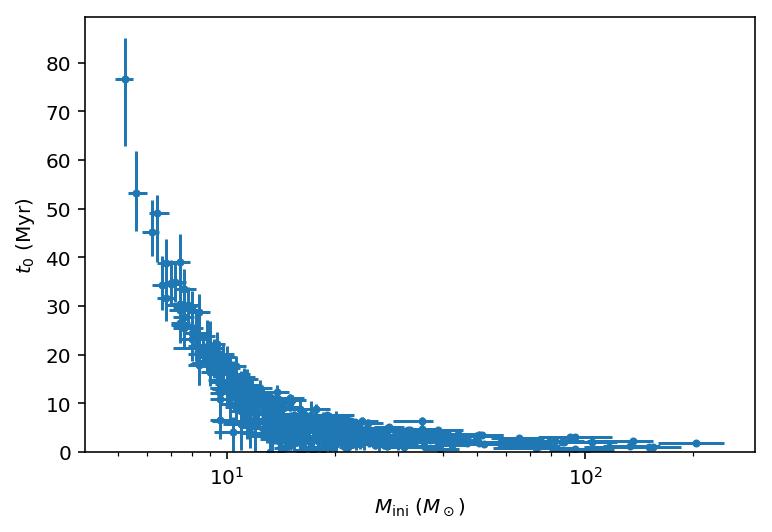

In [3]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', )
axis(ymin=0)
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
savefig('age-mass-all.pdf')

In [4]:
len(stellar_parameters_all), len(stellar_parameters)

(572, 400)

And restricting to $\Mini \geq 15 \, \MSun$:

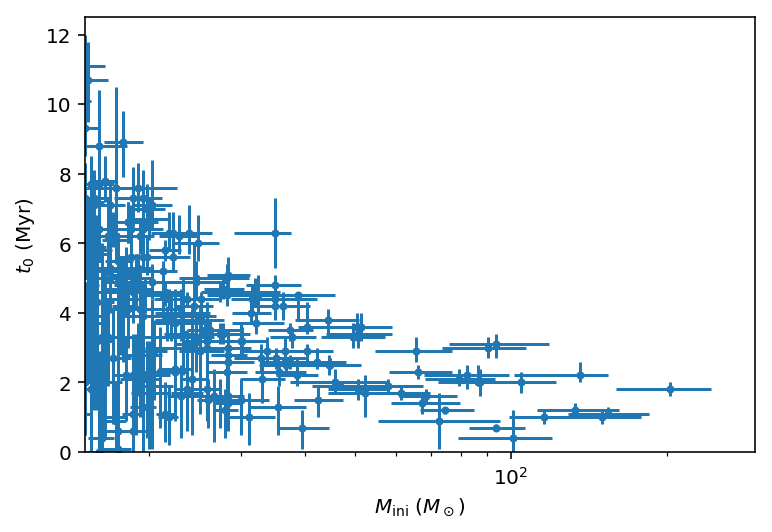

In [5]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.')
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=15, ymin=0, ymax=12.5)
savefig('age-mass-zoom.pdf')

I grabbed the non-rotating evolutionary models from [Brott, et al. (2011)](https://dx.doi.org/10.1051/0004-6361/201016113) from [VizieR](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/530/A115#sRM2.1).  I also grabbed `models.dat`, which gives the masses for the models.

Since 30 Dor has a metallicity around half the solar value, I think it is probably best to use the LMC lifetimes.

In [6]:
masses = []
lifetimes = []
for f in glob.glob('evol/f*.dat'):
    m = float(int(re.match('.*f([0-9]+)-.*', f).group(1)))
    lt = np.max(genfromtxt(f, delimiter='|', usecols=(0,)))
    masses.append(m)
    lifetimes.append(lt)
masses = array(masses)
lifetimes = array(lifetimes)
inds = argsort(masses)
masses = masses[inds]
lifetimes = lifetimes[inds]

The plot below is restricted to $M \geq 15 \, \MSun$.

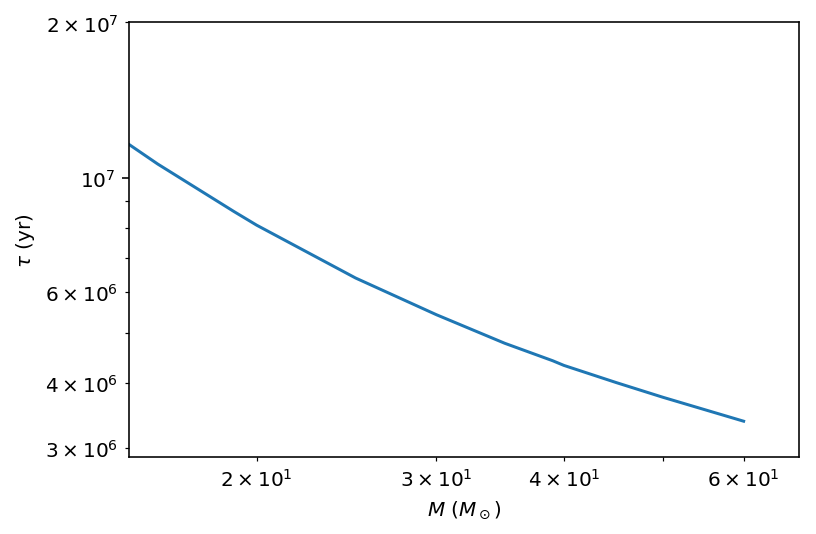

In [15]:
plot(masses, lifetimes)
xscale('log')
yscale('log')
axis(xmin=15, ymax=2e7)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

Let's try to interpret this as a power law (it's not, clearly, but maybe it's close).  Hmm, doesn't look too good:

(15, 57.23700725928984, -1.4, -0.50835948614594062)

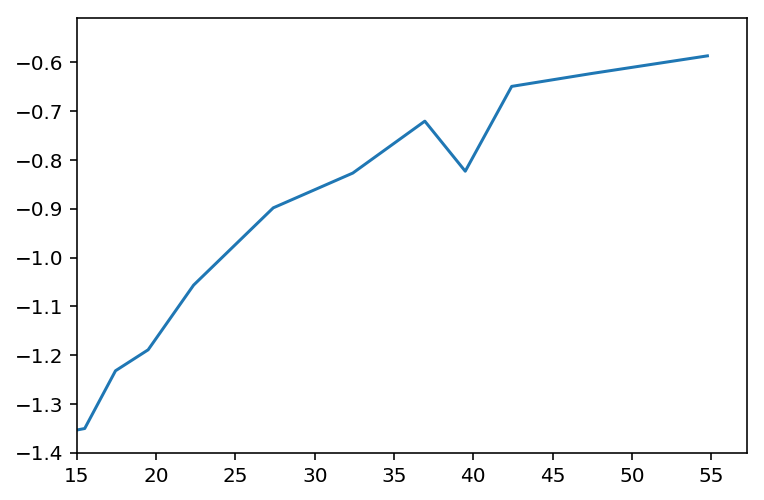

In [12]:
mid_masses = exp(0.5*(log(masses[1:]) + log(masses[:-1])))
plot(mid_masses, diff(log(lifetimes))/diff(log(masses)))
axis(xmin=15, ymin=-1.4)

OK.  How about a log-log fit to polynomials?

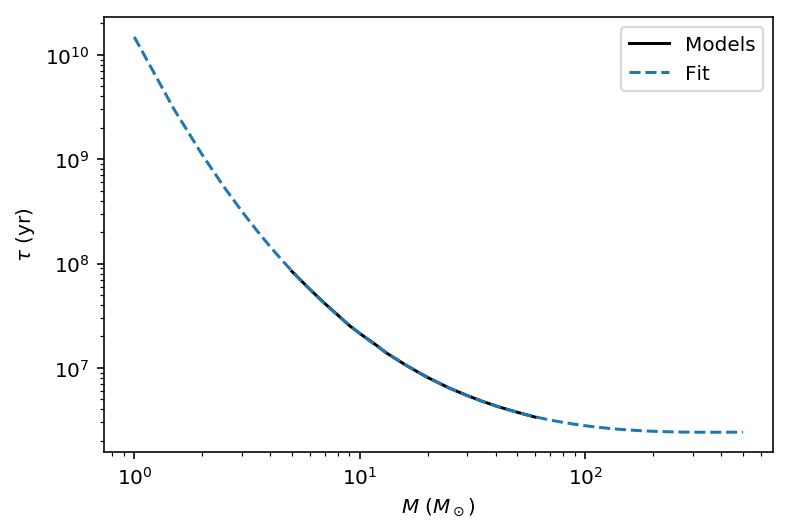

In [31]:
nmasses = masses.shape[0]
M = column_stack((ones(nmasses), log(masses), log(masses)**2, log(masses)**3))
c_lifetime = np.linalg.lstsq(M, log(lifetimes))[0]
plot(masses, lifetimes, '-k', label='Models')

fit_masses = linspace(1, 500, 1000)
Mfit = column_stack((ones(1000), log(fit_masses), log(fit_masses)**2, log(fit_masses)**3))

plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T)), '--', label='Fit')
xscale('log')
yscale('log')

legend(loc='best')

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

savefig('lifetime-fit.pdf')